# Analysis of Select University of Edinburgh Archival Metadata Descriptions

* **Source:** [University of Edinburgh Archive and Manuscript Collections](https://archives.collections.ed.ac.uk)
* **Content:** Descriptions from the archival catalog's *Title*, *Biographical / Historical*, *Scope and Contents*, and *Processing Information* metadata fields
* **Date extracted:** October 2020

***

**Table of Contents**
* [Exploratory Analysis](#exploratory-analysis)
  * [Counts by Description](#counts-by-description)
  * [Counts by Sentence](#counts-by-sentence)
  * [Counts Overall](#counts-overall)
* [Root Forms](#root-forms)
* [Grammatically and Lexically Gendered Word Counts](#grammatically-and-lexically-gendered-word-counts)
* [Part of Speech Tagging](#part-of-speech-tagging)
* [Concordances](#concordances)

***

In [18]:
import analysis_utils

import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger_eng')
from nltk.tag import pos_tag, pos_tag_sents
nltk.download('tagsets')  # part of speech tags

from pathlib import Path

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/lucyhavens/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


Create a directory to save analysis outputs to.

In [2]:
extracted_dir = "data/uoe/analysis/"
Path(extracted_dir).mkdir(parents=True, exist_ok=True)

Load the descriptive metadata extracted from NUSC's catalog as a DataFrame.

In [3]:
f = "data/uoe/all_token_data.csv"  #tagged_tokens.csv"

In [4]:
df = pd.read_csv(f, index_col=0)
print(df.shape)
df.head()

(779270, 8)


,description_id,sentence_id,ann_id,token_id,token,token_offsets,pos,tag
0,0,0,99999,0,Identifier,"(0, 10)",NN,O
1,0,0,99999,1,:,"(10, 11)",:,O
2,0,0,99999,2,AA5,"(12, 15)",NN,O
3,1,1,99999,3,Title,"(17, 22)",NN,O
4,1,1,99999,4,:,"(22, 23)",:,O


Remove the names of the metadata fields and the punctuation from the `token` column.

In [5]:
punctuation = list(string.punctuation)
print(punctuation)
field_names_tokens = ["Identifier", "Title", "Biographical", "Historical", "Scope", "Contents", "Processing", "Information"]
to_exclude = punctuation + field_names_tokens

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [6]:
sub_df = df[["description_id", "sentence_id", "token_id", "token", "pos"]]
sub_df = sub_df.drop_duplicates()
for char in to_exclude:
    sub_df = sub_df.loc[sub_df.token != char]
print(sub_df.shape)

(542635, 5)


In [7]:
sub_df.head()

,description_id,sentence_id,token_id,token,pos
2,0,0,2,AA5,NN
5,1,1,5,Papers,NNS
6,1,1,6,of,IN
7,1,1,7,The,DT
10,1,1,8,Very,NNP


Group the tokens and their pos tags by sentence and by description.

In [8]:
cols_to_groupby = ["description_id"]
cols_to_agg = ["sentence_id", "token_id", "token", "pos"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: x.tolist())
df_tokens = sub_df.groupby(cols_to_groupby).agg(agg_dict).reset_index()
df_tokens.head()

,description_id,sentence_id,token_id,token,pos
0,0,[0],[2],[AA5],[NN]
1,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 6, 7, 8, 9, 10, 11, 12, 14]","[Papers, of, The, Very, Rev, Prof, James, Whyt...","[NNS, IN, DT, NNP, NNP, NNP, NNP, NNP, CD]"
2,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[17, 20, 21, 22, 24, 26, 28, 30, 31, 32, 33, 3...","[and, Sermons, and, addresses, 1948-1996, lect...","[CC, NNS, CC, NNS, JJ, NNS, JJ, NN, NNS, CC, N..."
3,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[113, 114, 115, 116, 117, 118, 119, 120, 121, ...","[Professor, James, Aitken, White, was, a, lead...","[NNP, NNP, NNP, NNP, VBD, DT, JJ, JJ, NN, CC, ..."
4,4,[11],[310],[AA6],[NN]


In [9]:
cols_to_groupby = ["description_id", "sentence_id"]
cols_to_agg = ["token_id", "token", "pos"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: x.tolist())
df_sents = sub_df.groupby(cols_to_groupby).agg(agg_dict).reset_index()
df_sents.head()

,description_id,sentence_id,token_id,token,pos
0,0,0,[2],[AA5],[NN]
1,1,1,"[5, 6, 7, 8, 9, 10, 11, 12, 14]","[Papers, of, The, Very, Rev, Prof, James, Whyt...","[NNS, IN, DT, NNP, NNP, NNP, NNP, NNP, CD]"
2,2,2,"[17, 20, 21, 22, 24, 26, 28, 30, 31, 32, 33, 3...","[and, Sermons, and, addresses, 1948-1996, lect...","[CC, NNS, CC, NNS, JJ, NNS, JJ, NN, NNS, CC, N..."
3,3,3,"[113, 114, 115, 116, 117, 118, 119, 120, 121, ...","[Professor, James, Aitken, White, was, a, lead...","[NNP, NNP, NNP, NNP, VBD, DT, JJ, JJ, NN, CC, ..."
4,3,4,"[134, 135, 136, 137, 138, 139, 140, 141, 142, ...","[He, was, educated, at, Daniel, Stewart, 's, C...","[PRP, VBD, VBN, IN, NNP, NNP, POS, NNP, CC, DT..."


In [10]:
cols_to_groupby = ["description_id"]
cols_to_agg = ["sentence_id", "token_id", "token", "pos"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: x.tolist())
df_descs = df_sents.groupby(cols_to_groupby).agg(agg_dict).reset_index()
df_descs.head()

,description_id,sentence_id,token_id,token,pos
0,0,[0],[[2]],[[AA5]],[[NN]]
1,1,[1],"[[5, 6, 7, 8, 9, 10, 11, 12, 14]]","[[Papers, of, The, Very, Rev, Prof, James, Why...","[[NNS, IN, DT, NNP, NNP, NNP, NNP, NNP, CD]]"
2,2,[2],"[[17, 20, 21, 22, 24, 26, 28, 30, 31, 32, 33, ...","[[and, Sermons, and, addresses, 1948-1996, lec...","[[CC, NNS, CC, NNS, JJ, NNS, JJ, NN, NNS, CC, ..."
3,3,"[3, 4, 5, 6, 7, 8, 9, 10]","[[113, 114, 115, 116, 117, 118, 119, 120, 121,...","[[Professor, James, Aitken, White, was, a, lea...","[[NNP, NNP, NNP, NNP, VBD, DT, JJ, JJ, NN, CC,..."
4,4,[11],[[310]],[[AA6]],[[NN]]


In [32]:
df_descs.to_csv(extracted_dir + "uoe_descs.csv")

## Exploratory Analysis

In [11]:
sentences = list(df_descs["token"])
print(len(sentences[3]))
print(sentences[3][0])

8
['Professor', 'James', 'Aitken', 'White', 'was', 'a', 'leading', 'Scottish', 'Theologian', 'and', 'Moderator', 'of', 'the', 'General', 'Assembly', 'of', 'the', 'Church', 'of', 'Scotland']


In [12]:
tokens = list(df_tokens["token"])  # one list of tokens per description
print(tokens[1])
print(len(tokens[1]))

['Papers', 'of', 'The', 'Very', 'Rev', 'Prof', 'James', 'Whyte', '1920-2005']
9


In [13]:
tokens_flat = list(sub_df["token"])  # maintaining original capitalization
print(tokens_flat[0:10])

['AA5', 'Papers', 'of', 'The', 'Very', 'Rev', 'Prof', 'James', 'Whyte', '1920-2005']


In [14]:
tokens_flat_lower = [t.lower() for t in tokens_flat]  # lowercasing all tokens
print(tokens_flat_lower[:10])

['aa5', 'papers', 'of', 'the', 'very', 'rev', 'prof', 'james', 'whyte', '1920-2005']


### Counts by Description

In [16]:
sentence_counts = [len(sentence_list) for sentence_list in sentences]  # count of sentences per description
print("Mean:", np.mean(sentence_counts))
print("Median:", np.median(sentence_counts))
print("Standard Deviation:", np.std(sentence_counts))
print("Minimum:", np.min(sentence_counts))
print("Maximum:", np.max(sentence_counts))

Mean: 1.5015494378783512
Median: 1.0
Standard Deviation: 5.377457449631
Minimum: 1
Maximum: 742


In [21]:
token_counts = [len(token_list) for token_list in tokens]  # count of tokens per description
print("Mean:", np.mean(token_counts))
print("Median:", np.median(token_counts))
print("Standard Deviation:", np.std(token_counts))
print("Minimum:", np.min(token_counts))
print("Maximum:", np.max(token_counts))

Mean: 19.55300518881522
Median: 10.0
Standard Deviation: 97.62714507877716
Minimum: 1
Maximum: 14097


In [22]:
df_by_desc = pd.DataFrame({
    "sentences_per_description":[np.mean(sentence_counts), np.median(sentence_counts), np.std(sentence_counts), np.min(sentence_counts), np.max(sentence_counts)],
    "tokens_per_description":[np.mean(token_counts), np.median(token_counts), np.std(token_counts), np.min(token_counts), np.max(token_counts)]
}, index=["mean", "median", "standard_deviation", "minimum", "maximum"])
df_by_desc

,sentences_per_description,tokens_per_description
mean,1.501549,19.553005
median,1.000000,10.000000
standard_deviation,5.377457,97.627145
minimum,1.000000,1.000000
maximum,742.000000,14097.000000


### Counts by Sentence

In [23]:
tokens_by_sentence = list(df_sents["token"])
token_counts_by_sentence = [len(s) for s in tokens_by_sentence]
print(tokens_by_sentence[0])
print(token_counts_by_sentence[:10])

['AA5']
[1, 9, 63, 20, 19, 23, 37, 16, 22, 19]


In [24]:
print("Mean:", np.mean(token_counts_by_sentence))
print("Median:", np.median(token_counts_by_sentence))
print("Standard Deviation:", np.std(token_counts_by_sentence))
print("Minimum:", np.min(token_counts_by_sentence))
print("Maximum:", np.max(token_counts_by_sentence))

Mean: 13.021885723884717
Median: 9.0
Standard Deviation: 14.97473738394984
Minimum: 1
Maximum: 551


In [25]:
df_by_sent = pd.DataFrame({
    "tokens_per_sentence":[np.mean(token_counts_by_sentence), np.median(token_counts_by_sentence), np.std(token_counts_by_sentence), np.min(token_counts_by_sentence), np.max(token_counts_by_sentence)]
}, index=["mean", "median", "standard_deviation", "minimum", "maximum"])
df_by_sent

,tokens_per_sentence
mean,13.021886
median,9.000000
standard_deviation,14.974737
minimum,1.000000
maximum,551.000000


In [26]:
df_stats = pd.concat([df_by_desc, df_by_sent], axis=1)
df_stats

,sentences_per_description,tokens_per_description,tokens_per_sentence
mean,1.501549,19.553005,13.021886
median,1.000000,10.000000,9.000000
standard_deviation,5.377457,97.627145,14.974737
minimum,1.000000,1.000000,1.000000
maximum,742.000000,14097.000000,551.000000


### Counts Overall

In [27]:
assert len(df_descs.description_id.unique()) == df_descs.shape[0]
total_descriptions = df_descs.shape[0]
print("Total descriptions:", total_descriptions)
assert len(df_sents.sentence_id.unique()) == df_sents.shape[0]
total_sentences = df_sents.shape[0]
print("Total sentences:", total_sentences)
assert (len(tokens_flat) == sum(token_counts))
total_tokens = len(tokens_flat)
print("Total tokens:", total_tokens)

Total descriptions: 27752
Total sentences: 41671
Total tokens: 542635


In [28]:
print("Unique tokens: ", len(set(tokens_flat_lower)))

Unique tokens:  40949


In [29]:
df_total = pd.DataFrame({"sentences_per_description":total_sentences, "tokens_per_description":total_tokens, "tokens_per_sentence":total_tokens}, index=["total"])
df_total

,sentences_per_description,tokens_per_description,tokens_per_sentence
total,41671,542635,542635


In [30]:
df_stats = pd.concat([df_stats, df_total], axis=0)
df_stats

,sentences_per_description,tokens_per_description,tokens_per_sentence
mean,1.501549,19.553005,13.021886
median,1.000000,10.000000,9.000000
standard_deviation,5.377457,97.627145,14.974737
minimum,1.000000,1.000000,1.000000
maximum,742.000000,14097.000000,551.000000
total,41671.000000,542635.000000,542635.000000


Save the table of descriptive statistics as a CSV file.

In [31]:
df_stats.to_csv(extracted_dir + "uoe_ead_descs_oct2020_stats.csv")

### Root Forms
#### Lemmatize & Stem

In [69]:
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(string.digits))

In [70]:
print(stop_words)

{'but', 'into', 'it', 'to', '?', "he'll", "shan't", '+', "needn't", 'should', '@', 'some', "wouldn't", 'because', "she's", 'having', 'did', 'their', '.', "hadn't", '\\', "that'll", "wasn't", 'while', '#', 'with', 's', 'any', 'does', 'here', 'mustn', 'other', "we'll", 'ours', 'ourselves', '!', 'most', '_', 'll', 'then', 'as', 'will', 'further', 'herself', 'her', ')', 'you', "couldn't", 'being', 'nor', 'by', 'do', 'o', '(', 'no', 'once', 'had', "we've", 'when', 'between', 'own', '}', "i've", "i'm", 'was', 'our', 'theirs', 'yourself', 'weren', ':', '0', 'are', 'yourselves', '>', '6', 'we', 'in', 'out', 'very', 'wasn', 'your', 'about', 'each', "hasn't", "you've", "should've", 'she', 'down', "i'll", 'has', "won't", 'few', 'those', '3', '<', "haven't", 'doesn', 'can', '{', 'until', 'he', "i'd", 'don', 'where', "it'd", 'both', "shouldn't", 'off', 'why', 'hasn', '"', 'below', 'themselves', 'itself', 'and', "mustn't", 'who', ';', 'himself', 'his', 'through', 'after', '8', 'only', 'there', '*', 

In [ ]:
filtered_tokens = [t for t in tokens_flat_lower if t not in stop_words]
filtered_tokens = [t for t in filtered_tokens if t.isalpha()]
filtered_tokens_fdist = FreqDist(filtered_tokens)

In [71]:
wnl = nltk.WordNetLemmatizer()
lemmas = [wnl.lemmatize(t) for t in tokens_flat_lower if t.isalpha()]
filtered_lemmas = [l for l in lemmas if l not in stop_words]
print("Total lemmas: ", len(lemmas))
print("Total filtered lemmas: ", len(filtered_lemmas))
print("Unique lemmas: ", len(set(lemmas)))
print("Unique filtered lemmas: ", len(set(filtered_lemmas)))

Total lemmas:  495600
Total filtered lemmas:  321407
Unique lemmas:  27999
Unique filtered lemmas:  27869


In [72]:
ps = PorterStemmer()
stems = [ps.stem(t) for t in tokens_flat_lower if t.isalpha()]
filtered_stems = [s for s in stems if s not in stop_words]
print("Total stems: ", len(stems))
print("Total filtered stems: ", len(filtered_stems))
print("Unique stems: ", len(set(stems)))
print("Unique filtered stems: ", len(set(filtered_stems)))

Total stems:  495600
Total filtered stems:  326810
Unique stems:  24379
Unique filtered stems:  24264


In [73]:
print(lemmas[100:110])
print(stems[100:110])

['a', 'an', 'army', 'chaplain', 'and', 'then', 'in', 'wa', 'inducted', 'to']
['as', 'an', 'armi', 'chaplain', 'and', 'then', 'in', 'wa', 'induct', 'to']


In [80]:
print("Total alphabetic tokens:", len(filtered_tokens))

Total alphabetic tokens: 321023


<Axes: title={'center': 'Top 30 most common alphabetic tokens'}, xlabel='Samples', ylabel='Counts'>

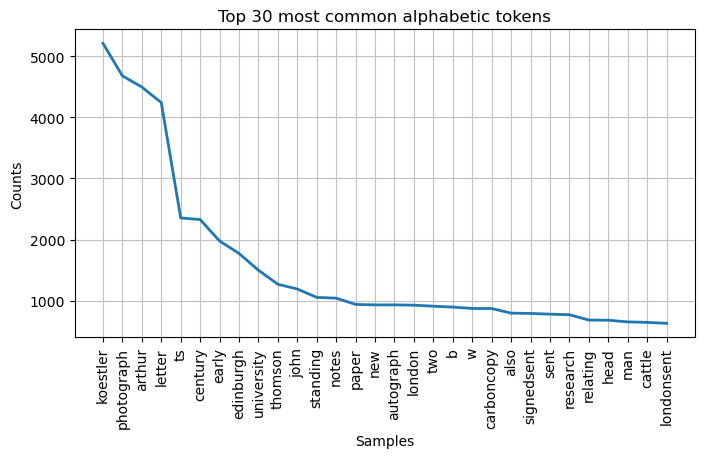

In [83]:
fdist_tokens = FreqDist(filtered_tokens)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30
fdist_tokens.plot(n, title=f"Top {n} most common alphabetic tokens")

<Axes: title={'center': 'Top 30 most common lemmas'}, xlabel='Samples', ylabel='Counts'>

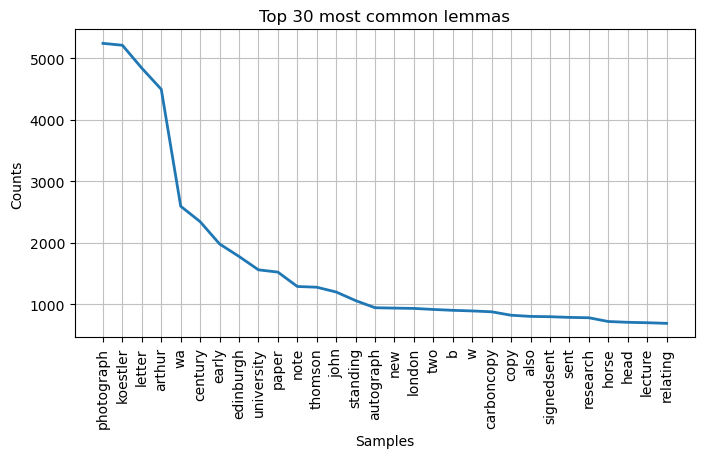

In [84]:
fdist_lemmas = FreqDist(filtered_lemmas)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30 #10
fdist_lemmas.plot(n, title=f"Top {n} most common lemmas")

<Axes: title={'center': 'Top 30 most common stems'}, xlabel='Samples', ylabel='Counts'>

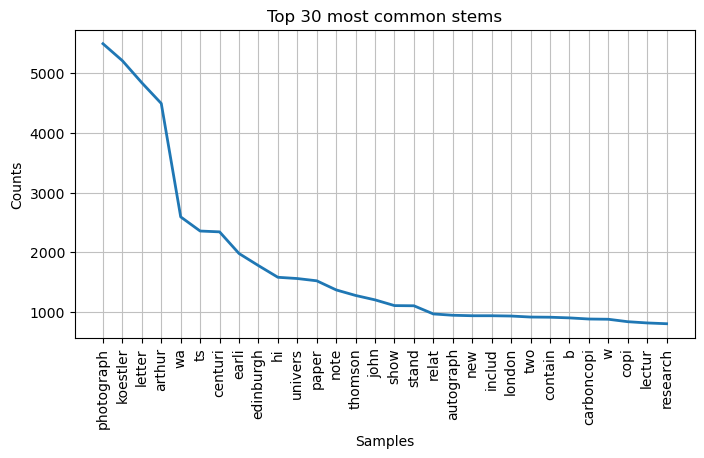

In [82]:
fdist_stems = FreqDist(filtered_stems)
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
n = 30 #10
fdist_stems.plot(n, title=f"Top {n} most common stems")

### Grammatically and Lexically Gendered Word Counts

In [15]:
word_list = [
    "woman", "women", "girl", "girls", "man", "men", "boy", "boys", 
    "she", "he", "her", "him", "hers", "his",
    "mother", "father", "daughter", "son", "sister", "brother",
    "aunt", "uncle", "niece", "nephew", "grandmother", "grandfather",
    "granddaughter", "grandson", "wife", "husband"
    ]

In [ ]:

lower_tokens_counts = []
for w in word_list:
    lower_tokens_counts += [filtered_tokens_fdist[w]]
lower_tokens_df = pd.DataFrame({"word":word_list, "count":lower_tokens_counts})
lower_tokens_df = lower_tokens_df.sort_values(by="count")
lower_tokens_df


,word,count
9,he,0
22,niece,0
13,his,0
12,hers,0
26,granddaughter,0
11,him,0
10,her,0
8,she,0
20,aunt,2
24,grandmother,4


In [ ]:
lower_tokens_df.to_csv(extracted_dir+"uoe_ead_gendered_lower_token_counts_oct2020.csv", index=False)

In [16]:
capitalized_word_list = [
    "Mrs", "Ms", "Miss", "Mr", "Messrs", "Lady", "Lord",
    "gentleman", "gentlemen", "ladies", "lady", "Duke", "Duchess",
    "King", "Queen", "Prince", "Princess", "Countess", "Count",
    "Baroness", "Baron", "Viscountess", "Viscount", "Dame", "Sir"
    ]

In [ ]:
cap_tokens_filtered = [t for t in tokens_flat if t.isalpha()]
cap_tokens_filtered = [t for t in cap_tokens_filtered if t not in stop_words]
cap_tokens_fdist = FreqDist(cap_tokens_filtered)
cap_tokens_counts = []
for w in capitalized_word_list:
    cap_tokens_counts += [cap_tokens_fdist[w]]
cap_tokens_df = pd.DataFrame({"word":capitalized_word_list, "count":cap_tokens_counts})
cap_tokens_df = cap_tokens_df.sort_values(by="count")
cap_tokens_df

,word,count
21,Viscountess,0
19,Baroness,1
7,gentleman,1
8,gentlemen,1
1,Ms,2
10,lady,2
9,ladies,3
4,Messrs,4
23,Dame,5
18,Count,6


In [ ]:
cap_tokens_df.to_csv(extracted_dir+"uoe_ead_gendered_capitalized_token_counts_oct2020.csv", index=False)

## Part of Speech Tagging

Use NLTK's default part-of-speech tagger to analyze the adjectives and adverbs of the descriptive metadata.

In [90]:
sub_df.head()

,description_id,sentence_id,token_id,token,pos
2,0,0,2,AA5,NN
5,1,1,5,Papers,NNS
6,1,1,6,of,IN
7,1,1,7,The,DT
10,1,1,8,Very,NNP


In [92]:
sub_df.tail()

,description_id,sentence_id,token_id,token,pos
779264,27907,42029,753926,Court,NNP
779265,27907,42029,753927,cases,NNS
779266,27907,42029,753928,involving,VBG
779267,27907,42029,753929,homosexual,JJ
779268,27907,42029,753930,offences,NNS


In [93]:
sub_df.to_csv(extracted_dir + "uoe_ead_descs_oct2020_pos_tags.csv", index=False)
# df_pos = pd.read_csv(extracted_dir + "uoe_ead_descs_oct2020_pos_tags.csv")
df_pos = sub_df
df_pos.head()

,description_id,sentence_id,token_id,token,pos
2,0,0,2,AA5,NN
5,1,1,5,Papers,NNS
6,1,1,6,of,IN
7,1,1,7,The,DT
10,1,1,8,Very,NNP


In [ ]:
df_pos.shape  # (542635, 5)

(542635, 5)

Confirm there are no `nan` values in the part-of-speech tag column, `pos`, that need to be replaced with with an empty string (the entire column should only contain string values).

In [ ]:
print(df_pos["pos"].unique())

['NN' 'NNS' 'IN' 'DT' 'NNP' 'CD' 'CC' 'JJ' 'RB' 'VBD' 'PRP' 'VBN' 'POS'
 'WRB' 'PRP$' 'TO' 'VB' 'VBG' 'WDT' 'VBP' 'JJR' 'VBZ' 'WP' 'JJS' 'NNPS'
 'MD' '$' 'RBR' '...' '..' 'RP' "''" 'EX' 'PDT' 'SYM' 'FW' 'WP$' '–' 'UH'
 '``' 'RBS' '--' '…' '×' '—' '©' '……' '•']


You can see what each of these tags indicates [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).  We're particularly interested in adjectives and adverbs, which are represented with the following tags:
* `JJ` - adjective
* `JJR` - comparative adjective
* `JJS` - superlative adjective
* `RB` - adverb
* `RBR` - comparative adverb
* `RBS` - superlative adverb

In [96]:
df_jj = df_pos.loc[df_pos["pos"] == "JJ"]
df_jjr = df_pos.loc[df_pos["pos"] == "JJR"]
df_jjs = df_pos.loc[df_pos["pos"] == "JJS"]
print(df_jj.shape[0], df_jjr.shape[0], df_jjs.shape[0])

31840 307 285


In [97]:
df_adj = pd.concat([df_jj, df_jjr, df_jjs], axis=0)
print("Total adjectives:", df_adj.shape[0])
df_adj.head()

Total adjectives: 32432


,description_id,sentence_id,token_id,token,pos
40,2,2,24,1948-1996,JJ
44,2,2,28,1949-1982,JJ
52,2,2,36,1949-1982,JJ
56,2,2,40,1988-1989,JJ
58,2,2,42,1964-1970,JJ


Create a table of all the tokens tagged as adjectives (i.e., `JJ`, `JJR`, and `JJS`) with a count of their occurrence across the EAD metadata descriptions extracted from NUSC's catalog.

In [98]:
sub_df_adj = df_adj[["pos", "token"]]
cols_to_agg = ["pos"]
cols_to_groupby = ["token"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adj_tokens = sub_df_adj.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adj_tokens = df_adj_tokens.rename(columns={"pos": "count"})
df_adj_tokens = df_adj_tokens.sort_values(by="count", ascending=False)
df_adj_tokens.head()

,count
token,
20th,2143
early,1552
late,465
various,433
Scottish,413


In [99]:
df_adj_tokens.to_csv(extracted_dir + "uoe_descs_oct2020_nltk_adj_token_counts.csv")

Now do the same with tokens tagged as adverbs (i.e., `RB`, `RBR`, and `RBS`).

In [100]:
df_rb = df_pos.loc[df_pos["pos"] == "RB"]
df_rbr = df_pos.loc[df_pos["pos"] == "RBR"]
df_rbs = df_pos.loc[df_pos["pos"] == "RBS"]
print(df_rb.shape[0], df_rbr.shape[0], df_rbs.shape[0])

5614 95 54


In [101]:
df_adv = pd.concat([df_rb, df_rbr, df_rbs], axis=0)
print("Total adverbs:", df_adv.shape[0])
df_adv.head()

Total adverbs: 5763


,description_id,sentence_id,token_id,token,pos
118,2,2,102,also,RB
184,3,5,166,then,RB
245,3,7,227,also,RB
283,3,9,265,widely,RB
427,6,14,406,also,RB


In [102]:
sub_df_adv = df_adv[["pos", "token"]]
cols_to_agg = ["pos"]
cols_to_groupby = ["token"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adv_tokens = sub_df_adv.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adv_tokens = df_adv_tokens.rename(columns={"pos": "count"})
df_adv_tokens = df_adv_tokens.sort_values(by="count", ascending=False)
df_adv_tokens.head()

,count
token,
also,591
not,411
early,405
then,297
Also,208


In [103]:
df_adv_tokens.to_csv(extracted_dir + "uoe_descs_oct2020_nltk_adv_token_counts.csv")

**Note:** the capitalization of tokens should be considered when using these counts!  Let's make the same tables but with all tokens lowercased.

In [104]:
sub_df_adj = df_adj[["pos", "token"]]
sub_df_adj = sub_df_adj.fillna('')
token_col = list(sub_df_adj["token"])
new_token_col = [t.lower() for t in token_col]
sub_df_adj.insert(0, "token_lower", new_token_col)
sub_df_adj = sub_df_adj.drop(columns=["token"])

cols_to_agg = ["pos"]
cols_to_groupby = ["token_lower"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adj_tokens = sub_df_adj.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adj_tokens = df_adj_tokens.rename(columns={"pos": "count"})
df_adj_tokens = df_adj_tokens.sort_values(by="count", ascending=False)
df_adj_tokens.head()

,count
token_lower,
20th,2143
early,1569
various,478
late,468
scottish,415


In [105]:
sub_df_adv = df_adv[["pos", "token"]]
sub_df_adj = sub_df_adv.fillna('')
token_col = list(sub_df_adv["token"])
new_token_col = [t.lower() for t in token_col]
sub_df_adv.insert(0, "token_lower", new_token_col)
sub_df_adv = sub_df_adv.drop(columns=["token"])

cols_to_agg = ["pos"]
cols_to_groupby = ["token_lower"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adv_tokens = sub_df_adv.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adv_tokens = df_adv_tokens.rename(columns={"pos": "count"})
df_adv_tokens = df_adv_tokens.sort_values(by="count", ascending=False)
df_adv_tokens.head()

,count
token_lower,
also,799
not,425
early,406
then,306
as,146


Save these as CSVs, too!

In [106]:
df_adj_tokens.to_csv(extracted_dir + "uoe_descs_oct2020_nltk_adj_token_lower_counts.csv")
df_adv_tokens.to_csv(extracted_dir + "uoe_descs_oct2020_nltk_adv_token_lower_counts.csv")

Next, let's look at the adjectives and adverbs per description.

In [115]:
sub_df_adj = df_adj[["description_id", "pos"]]
cols_to_agg = ["pos"]
cols_to_groupby = ["description_id"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adj_grouped = sub_df_adj.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_descriptors = df_adj_grouped.rename(columns={"pos": "adj_count"})
df_descriptors.head()

,adj_count
description_id,
2,15
3,10
6,12
7,16
10,11


In [116]:
sub_df_adv = df_adj[["description_id", "pos"]]
cols_to_agg = ["pos"]
cols_to_groupby = ["description_id"]
agg_dict = dict.fromkeys(cols_to_agg, lambda x: len(x.tolist()))
df_adv_grouped = df_adv.groupby(cols_to_groupby).agg(agg_dict).reset_index().set_index(cols_to_groupby)
df_adv_grouped = df_adv_grouped.rename(columns={"pos": "adv_count"})
df_adv_grouped.tail()

,adv_count
description_id,
27766,4
27769,1
27773,1
27893,1
27902,1


In [117]:
df_descriptors = df_descriptors.join(
    df_adv_grouped, 
    on=["description_id"], how="outer"
    )
df_counts = df_descriptors.fillna(0)
df_counts.head()

,description_id,adj_count,adv_count
2.0,2,15.0,1.0
3.0,3,10.0,3.0
6.0,6,12.0,1.0
7.0,7,16.0,6.0
10.0,10,11.0,1.0


In [118]:
df_counts.to_csv(extracted_dir + "uoe_descs_oct2020_nltk_adj_adv_counts.csv")

In [119]:
col = "adj_count"
total_adjs = np.sum(df_counts[col])
mean_adjs = np.mean(df_counts[col])
median_adjs = np.median(df_counts[col])
min_adjs = np.min(df_counts[col])
max_adjs = np.max(df_counts[col])

In [120]:
col = "adv_count"
total_advs = np.sum(df_counts[col])
mean_advs = np.mean(df_counts[col])
median_advs = np.median(df_counts[col])
min_advs = np.min(df_counts[col])
max_advs = np.max(df_counts[col])

In [121]:
df_counts = pd.DataFrame({
        "adj_by_desc":[mean_adjs, median_adjs, min_adjs, max_adjs, total_adjs],
        "adv_by_desc":[mean_advs, median_advs, min_advs, max_advs, total_advs]
        }, index=["mean", "median", "minimum", "maximum","total"]
                 )
df_counts

,adj_by_desc,adv_by_desc
mean,2.625435,0.466526
median,2.000000,0.000000
minimum,0.000000,0.000000
maximum,1290.000000,252.000000
total,32432.000000,5763.000000


In [122]:
df_counts.to_csv(extracted_dir + "uoe_oct2020_nltk_adj_adv_stats.csv")

## Concordances

In [17]:
text = Text(tokens_flat)

Create concordances for the grammatically and lexically gendered words examined above.

In [19]:
gendered_words = word_list + capitalized_word_list
df_gend_conc = analysis_utils.makeConcordanceDF(text, gendered_words)
df_gend_conc.head()

,left,query,right
0,1954 invitations refused General 1955 General ...,woman,'s Forum General 1957 Companion of Honour lett...
1,lectures in Intermediate Honours Metaphysics a...,woman,'s Forum at which John Baillie delivered a lec...
2,Kennedy-Fraser manuscripts deposited in 1967 V...,woman,in a dramatic pose Discarded archive envelope ...
3,a Cheathaich from Mrs Cameron 'Mingulay Song '...,woman,Man lost on hills takes shelter in sheiling 'M...
4,it from a piper 'Gur Milis Morag Barra Version...,woman,Lament on a boat going down the men drowned Ar...


Save the result.

In [20]:
df_gend_conc.to_csv(extracted_dir + "uoe_concordance_gendered_words.csv")

Create concordances for a selection of the most common adjectives that seem to express a value judgement.

In [21]:
# Examine adjectives that seem to communicate a value judgement
adjs = ["key", "historic", "influential", "notable", "significant", "successful",
      "major", "distinctve", "remarkable", "all-time", "widely-read"]
df_adj_conc = analysis_utils.makeConcordanceDF(text, adjs)
df_adj_conc.head()

,left,query,right
0,In 1953 the Tell Scotland committee was formed...,key,figure in the Scottish evangelical movement of...
1,Dundee 18 April 1920 marked D.8835/49 Lowland ...,key,by Lachlan Macbean D.8835/49 EUL Special Colle...
2,versions of published songs manuscripts severa...,key,or for general use and 'Loom Blessing manuscri...
3,to the Sea words by Violet Jacob air from Barr...,key,'' A Quern Lilt Ash Eve 'Obbe S Harris 'On her...
4,versions of published songs manuscripts severa...,key,or for general use and 'Loom Blessing manuscri...


Save the result.

In [22]:
df_adj_conc.to_csv(extracted_dir + "uoe_concordance_common_adjs.csv")